# Notebook overview

# Imports
## Libraries

In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import gc, warnings, os, time
import mlflow
import importlib

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from transformers import ApplicationCleaner
from pipelines import PIPELINES, DEFAULT_CONFIG

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, fbeta_score, roc_curve, RocCurveDisplay

from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

# Pipeline

In [492]:
def display_scores(y_true, y_pred, y_pred_proba, name=''):
    print('-------------------------')
    print(f'ROC AUC: {roc_auc_score(y_true, y_pred)}')
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred, normalize=True), 2)}')
    print(f'Fbeta score(b=10): {fbeta_score(y_true, y_pred, beta=10)}')
    print(f'Classification report: {classification_report(y_true, y_pred, zero_division=0)}')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    #create ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name)
    display.plot()
    
    print('-------------------------')

In [493]:
def train(pipeline_name, config, dev_mode=True):
    print('Training the model')
    time_start = time.time()

    data = process.load_data(dev_mode)

    X = data['application'].drop(process.TARGET_COLUMN, axis=1)
    y = data['application'][process.TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)

    print('Train shape: {}'.format(X_train.shape))
    print('Valid shape: {}'.format(y_train.shape))

    pipeline = PIPELINES[pipeline_name](config=config)

    print('Start pipeline fit and transform')
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[::,1]

    display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)
    
    exec_time = round((time.time() - time_start), 2)
    print(f'execution time: {exec_time} seconds \n')

# Experiments
## Dummy classifier

Set the baseline with the Dummy Classifier

Training the model
Loading application_train ...


2023/11/14 11:40:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '818a498c896140ebb73efca93fd6abb4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/14 11:40:35 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/14 11:40:35 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/14 11:40:37 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow Data

-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 8.03 seconds 



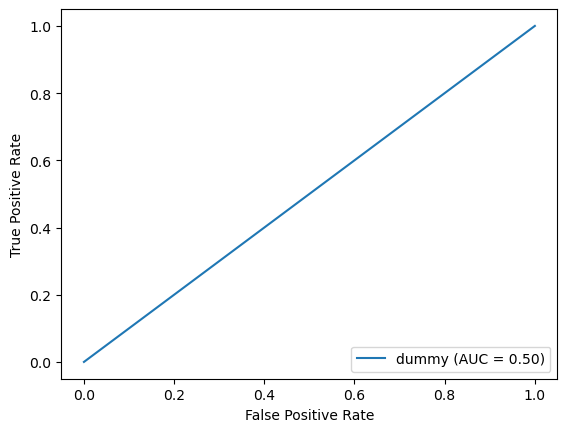

In [443]:
train('dummy', config={'strategy': 'prior'}, dev_mode=False)

TODO: explanation

## Logistic Regression

We will start with the most simple configuration.

In [494]:
# Set the experiment
mlflow.set_experiment("Logistic Regression")

# Track models automatically
mlflow.sklearn.autolog()

In [495]:
config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_oversample': False,
    },
    'model_params': {
        'random_state': 42
    }
}

2023/11/14 19:17:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '33b5d3eae3d945eabe00aad6dda117c6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/11/14 19:17:11 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/14 19:17:11 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/14 19:17:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Training the model
Loading application_train ...
Loading Done.
Train shape: (800, 121)
Valid shape: (800,)
Start pipeline fit and transform
Fitting cleaner
Transforming cleaner
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.0s
Fitting FE
Transforming FE
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
Fitting Imputer
Transforming Imputer
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   0.0s
Fitting scalar
Transforming scalar
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.0s


2023/11/14 19:17:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a7da993da3094ba7b391bfb9cb567e3d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/11/14 19:17:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integ

[Pipeline] ........ (step 5 of 7) Processing oversample, total=   1.8s
Fitting Encoder
Transforming Encoder
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   0.0s


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/14 19:17:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever

[Pipeline] ........ (step 7 of 7) Processing classifier, total=   1.5s
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming scalar
Transforming Encoder
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming scalar
Transforming Encoder
-------------------------
ROC AUC: 0.5
Accuracy: 0.08
Fbeta score(b=10): 0.8977777777777778
Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.08      1.00      0.15        16

    accuracy                           0.08       200
   macro avg       0.04      0.50      0.07       200
weighted avg       0.01      0.08      0.01       200

-------------------------
execution time: 3.39 seconds 



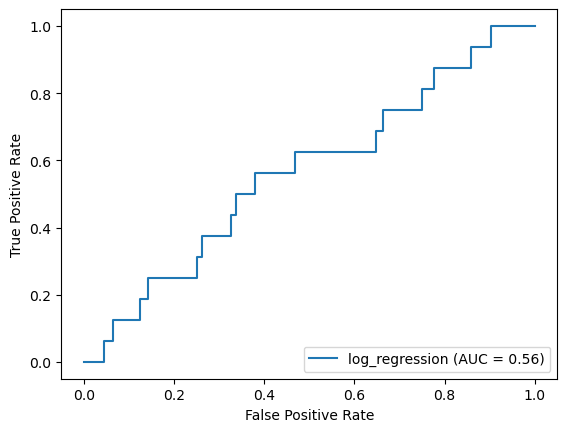

In [496]:
# test on sample
config['preprocessing']['should_oversample'] = True

train('log_regression', config, dev_mode=True)

### Baseline

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/14 18:07:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('encoder', ApplicationEncoder()),
                ('scalar', ApplicationScaler(scaler=StandardScaler()))],
         verbose=True)), ('class...`
2023/11/14 18:08:01 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


Fitting cleaner
Transforming cleaner
[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.1s
Fitting FE
Transforming FE
[Pipeline] . (step 2 of 5) Processing feature_extractor, total=   0.0s
Fitting Imputer
Transforming Imputer
[Pipeline] ........... (step 3 of 5) Processing imputer, total=   3.3s
Fitting Encoder
Transforming Encoder
[Pipeline] ........... (step 4 of 5) Processing encoder, total=   1.3s
Fitting scalar
Transforming scalar
[Pipeline] ............ (step 5 of 5) Processing scalar, total=   0.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


2023/11/14 18:08:25 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


2023/11/14 18:08:28 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


2023/11/14 18:08:29 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 32.3 seconds 



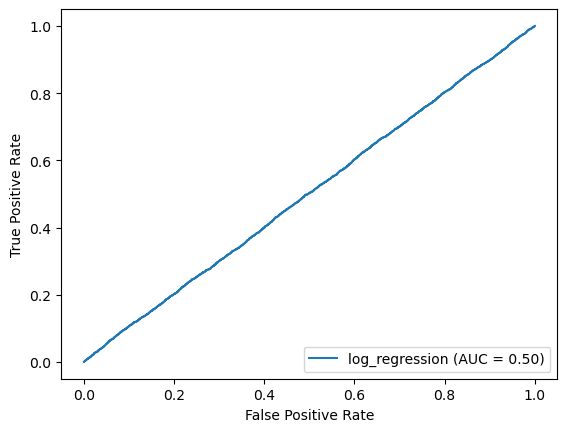

In [460]:
with mlflow.start_run(run_name = 'log_regression_baseline'):
    train('log_regression', config, dev_mode=False)

mlflow.end_run()

### With SMOTE

In [467]:
config['preprocessing']['should_oversample'] = True

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
Fitting cleaner
Transforming cleaner
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.1s
Fitting FE
Transforming FE
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
Fitting Imputer
Transforming Imputer
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   3.3s
Fitting Encoder
Transforming Encoder
[Pipeline] ........... (step 4 of 7) Processing encoder, total=   1.3s
Fitting scalar
Transforming scalar
[Pipeline] ............ (step 5 of 7) Processing scalar, total=   0.9s


2023/11/14 18:33:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/14 18:33:46 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/14 18:33:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ........ (step 6 of 7) Processing oversample, total=   3.9s


2023/11/14 18:34:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/14 18:34:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  16.5s
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


2023/11/14 18:34:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Transforming cleaner
Transforming FE
Transforming Imputer
Transforming Encoder
Transforming scalar


2023/11/14 18:34:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.6466752008001413
Accuracy: 0.69
Fbeta score(b=10): 0.5806469371544517
Classification report:               precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.14      0.60      0.23      4884

    accuracy                           0.69     61503
   macro avg       0.55      0.65      0.52     61503
weighted avg       0.89      0.69      0.76     61503

-------------------------
execution time: 31.64 seconds 



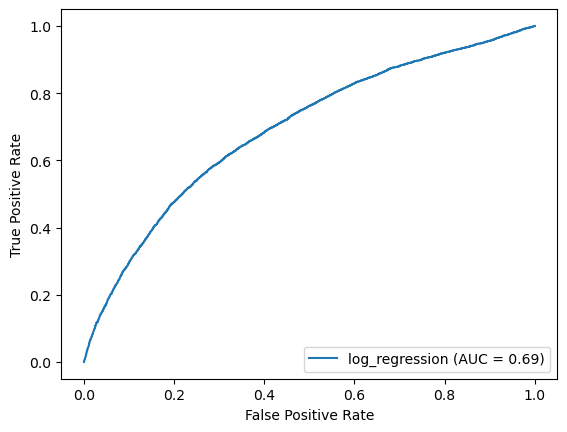

In [468]:
with mlflow.start_run(run_name = 'log_regression_base_oversampling'):
    train('log_regression', config, dev_mode=False)

mlflow.end_run()

### With SMOTENC

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
Fitting cleaner
Transforming cleaner
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.3s
Fitting FE
Transforming FE
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
Fitting Imputer
Transforming Imputer
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   2.5s
Fitting scalar
Transforming scalar
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.3s


2023/11/14 19:18:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/14 19:18:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/14 19:18:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ........ (step 5 of 7) Processing oversample, total= 4.4min
Fitting Encoder
Transforming Encoder
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   2.6s


2023/11/14 19:22:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/14 19:22:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  16.5s
Transforming cleaner
Transforming FE
Transforming Imputer
Transforming scalar
Transforming Encoder


2023/11/14 19:22:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Transforming cleaner
Transforming FE
Transforming Imputer
Transforming scalar
Transforming Encoder


2023/11/14 19:22:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.6329543333596743
Accuracy: 0.76
Fbeta score(b=10): 0.46890216734031376
Classification report:               precision    recall  f1-score   support

           0       0.95      0.79      0.86     56619
           1       0.16      0.48      0.24      4884

    accuracy                           0.76     61503
   macro avg       0.55      0.63      0.55     61503
weighted avg       0.88      0.76      0.81     61503

-------------------------
execution time: 293.76 seconds 



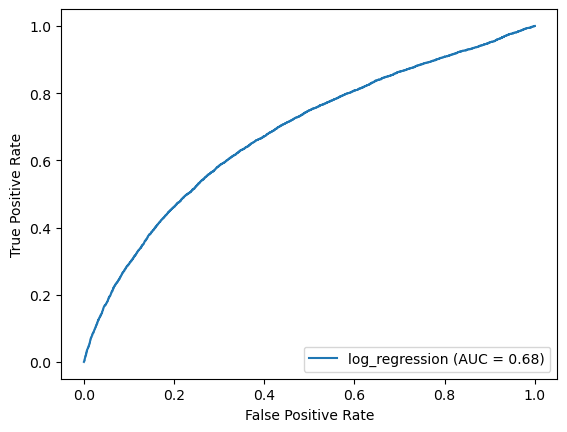

In [497]:
config['preprocessing']['should_oversample'] = True
with mlflow.start_run(run_name = 'log_regression_base_smotenc'):
    train('log_regression', config, dev_mode=False)

mlflow.end_run()